In [4]:
!pip install scikit-optimize
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import randint,uniform
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt.pyll.base import scope
from functools import partial
import random
from skopt import space, gp_minimize
from sklearn.utils import resample, shuffle

RANDOM_STATE = 42
N_SPLITS = 10
kf = KFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=True)
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle= True)
SCORING = "accuracy"
EVALS_IN_HYPEROPT = 3000
EVALS_IN_BAYESIAN = 500
EVALS_IN_RANDOM = 5000
FOLDS = skf
N_JOBS = -1

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
def print_params(classifier):
  print("Trenutni parametri modela:")
  for param, value in classifier.get_params().items():
    print(f"{param}: {value}")

In [6]:
def print_scores_with_cross_val(classifier, optimization_algo = ""):
  print(f'Točnost modela {optimization_algo} sa unakrsnom provjerom: {cross_val_score(classifier, X, y, cv=FOLDS, scoring="accuracy", n_jobs=N_JOBS).mean() * 100}%')
  print(f'Standardna devijacija modela {optimization_algo} sa unakrnsom provjerom: {cross_val_score(classifier, X, y, cv=FOLDS, scoring="accuracy", n_jobs=N_JOBS).std() * 100} %')
  print(f'ROC AUC vrijednost modela {optimization_algo} : {cross_val_score(classifier, X, y, cv=10, scoring="roc_auc", n_jobs=N_JOBS).mean() * 100} %')
  print(f'F1 vrijednost modela {optimization_algo} : {cross_val_score(classifier, X, y, cv=10, scoring="f1", n_jobs=N_JOBS).mean() * 100} %')

In [7]:
dataset = pd.read_csv('water_potability.csv')


In [8]:
dataset.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [9]:
dataset.ph = dataset.ph.fillna(dataset.ph.mean())
dataset.Sulfate = dataset.Sulfate.fillna(dataset.Sulfate.mean())
dataset.Trihalomethanes = dataset.Trihalomethanes.fillna(dataset.Trihalomethanes.mean())

In [10]:
zero  = dataset[dataset['Potability']==0]
one = dataset[dataset['Potability']==1]
dataset_minority_upsampled = resample(one, replace = True, n_samples = 1200, random_state =RANDOM_STATE) 
dataset = pd.concat([zero, dataset_minority_upsampled])
dataset = shuffle(dataset, random_state=RANDOM_STATE) 

In [11]:
dataset.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000
mean,7.085299,195.966292,21932.729508,7.157705,333.914847,426.248249,14.290948,66.388968,3.960728,0.375235
std,1.451207,33.288296,8694.697529,1.565831,35.465996,81.730425,3.310196,15.780525,0.781109,0.484259
min,0.000000,47.432000,320.942611,0.530351,187.170714,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.284536,175.931744,15621.042015,6.163502,317.285500,365.695713,12.084591,56.743869,3.438465,0.000000
50%,7.080795,196.928061,20882.160702,7.145835,333.775777,421.136657,14.252898,66.396293,3.950530,0.000000
75%,7.871417,216.757733,27196.306175,8.137345,350.305293,483.784905,16.585797,76.762017,4.485903,1.000000
max,14.000000,323.124000,61227.196008,12.912187,475.737460,753.342620,28.300000,124.000000,6.739000,1.000000


In [12]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, shuffle=True)

In [14]:
lgbm_classic= LGBMClassifier(random_state=RANDOM_STATE)

In [15]:
lgbm_classic.fit(X_train, y_train)
y_pred = lgbm_classic.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"Točnost LGBM klasifikatora bez unakrsne provjere: {lgbm_classic.score(X_test, y_test) * 100} %")

[[363  54]
 [ 76 147]]
Točnost LGBM klasifikatora bez unakrsne provjere: 79.6875 %


In [16]:
print_params(lgbm_classic)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.1
max_depth: -1
min_child_samples: 20
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 100
n_jobs: -1
num_leaves: 31
objective: None
random_state: 42
reg_alpha: 0.0
reg_lambda: 0.0
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


In [17]:
%%time
params_grid_search = {'learning_rate': [0.001, 0.01, 0.5],
          'num_leaves': [10, 20, 150, 300],
          'n_estimators': [500, 1500, 3000],
          'max_depth': [3, 8, 12],
          'min_child_samples': [5, 30, 150],
          'reg_lambda': [1, 50, 99],
          'reg_alpha' : [1, 50, 99]}
grid_search = GridSearchCV(estimator=LGBMClassifier(random_state=RANDOM_STATE),
                           param_grid=params_grid_search,
                           scoring=SCORING,
                           cv=FOLDS,
                           n_jobs=N_JOBS,
                           return_train_score=True,
                           verbose=10)
grid_search.fit(X, y)
print(f"Najbolja točnost sa Grid Search-om: {grid_search.best_score_ * 100} %")
print(f"Najbolji parametri sa Grid Search-om: {grid_search.best_params_}")

Fitting 10 folds for each of 2916 candidates, totalling 29160 fits
Najbolja točnost sa Grid Search-om: 81.8639302507837 %
Najbolji parametri sa Grid Search-om: {'learning_rate': 0.01, 'max_depth': 12, 'min_child_samples': 5, 'n_estimators': 3000, 'num_leaves': 300, 'reg_alpha': 1, 'reg_lambda': 50}
CPU times: total: 2min 37s
Wall time: 47min 7s


In [18]:
lgbm_grid_search = LGBMClassifier(**grid_search.best_params_)
lgbm_grid_search.set_params(random_state = RANDOM_STATE )
print_params(lgbm_grid_search)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.01
max_depth: 12
min_child_samples: 5
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 3000
n_jobs: -1
num_leaves: 300
objective: None
random_state: 42
reg_alpha: 1
reg_lambda: 50
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

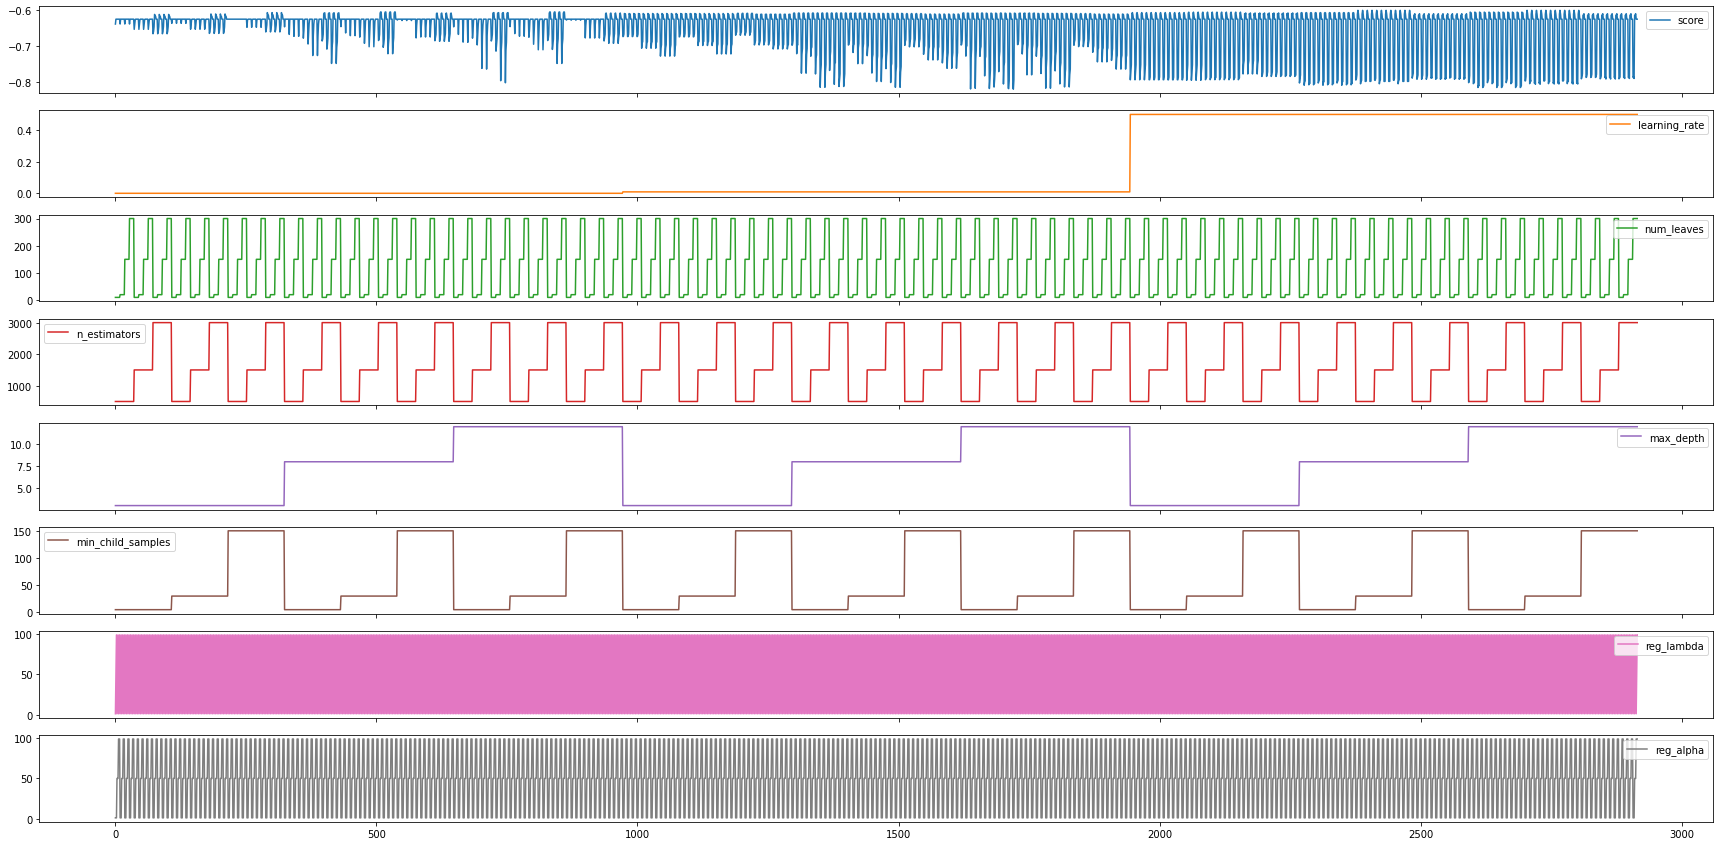

In [19]:
grid_search_scores = grid_search.cv_results_
grid_search_results_df=pd.DataFrame(np.transpose([-grid_search_scores['mean_test_score'],
                                         grid_search_scores['param_learning_rate'].data,
                                         grid_search_scores['param_num_leaves'].data,
                                         grid_search_scores['param_n_estimators'].data,
                                         grid_search_scores['param_max_depth'].data,
                                         grid_search_scores['param_min_child_samples'].data,
                                         grid_search_scores['param_reg_lambda'].data,
                                         grid_search_scores['param_reg_alpha'].data]),
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
grid_search_results_df.plot(subplots=True, figsize=(30, 15))

In [20]:
%%time
params_random_search = {'learning_rate' : uniform(0.01,0.99),
          'num_leaves': randint(20,3000),
          'n_estimators': randint(500,3000),
          'max_depth': randint(3,12),
          'min_child_samples': randint(2,300),
          'reg_lambda': uniform(0.01,99.99),
          'reg_alpha': uniform(0.01,99.99),
          }
random_search = RandomizedSearchCV(estimator = LGBMClassifier(random_state=RANDOM_STATE),
                                   param_distributions = params_random_search,
                                   n_iter = EVALS_IN_RANDOM,
                                   scoring = SCORING,
                                   cv = FOLDS,
                                   random_state = RANDOM_STATE,
                                   n_jobs = N_JOBS,
                                   verbose=10
                                   )
random_search.fit(X, y)
print("Najbolja točnost sa Random Search-om: {:.2f} %".format(random_search.best_score_*100))
print("Najbolji parametri prema Random Search-om:", random_search.best_params_)

Fitting 10 folds for each of 5000 candidates, totalling 50000 fits
Najbolja točnost sa Random Search-om: 80.83 %
Najbolji parametri prema Random Search-om: {'learning_rate': 0.6683814440851101, 'max_depth': 10, 'min_child_samples': 6, 'n_estimators': 2659, 'num_leaves': 292, 'reg_alpha': 1.3542699579017912, 'reg_lambda': 20.470501001176398}
CPU times: total: 1min 25s
Wall time: 23min 51s


In [21]:
lgbm_random_search = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_random_search.set_params(**random_search.best_params_)
print_params(lgbm_random_search)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.6683814440851101
max_depth: 10
min_child_samples: 6
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 2659
n_jobs: -1
num_leaves: 292
objective: None
random_state: 42
reg_alpha: 1.3542699579017912
reg_lambda: 20.470501001176398
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

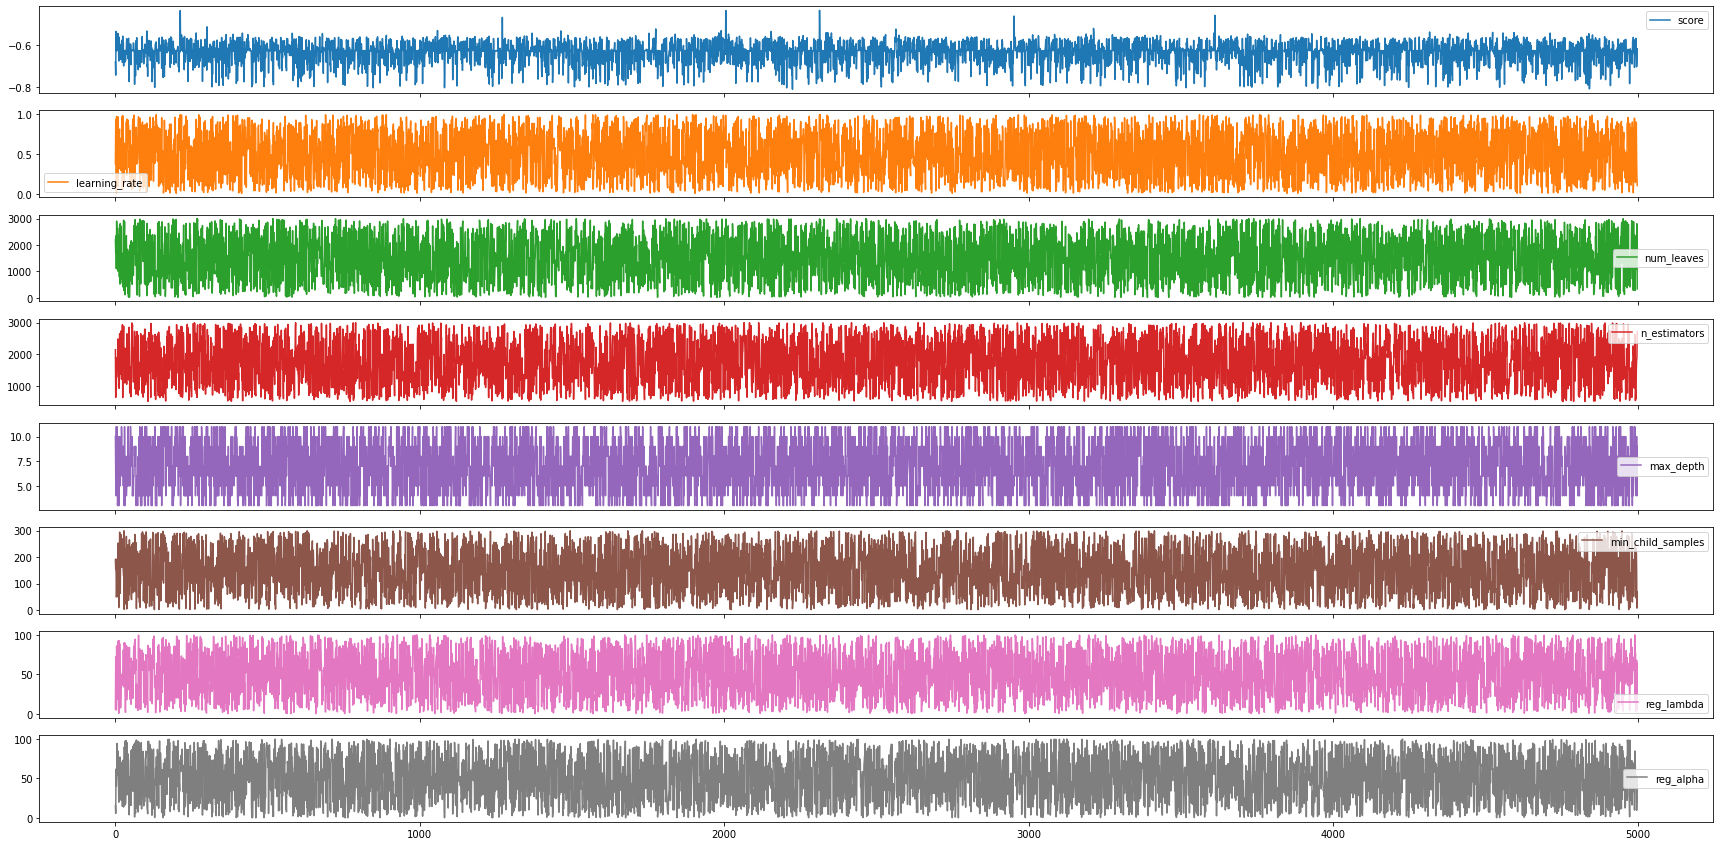

In [22]:
random_search_scores = random_search.cv_results_
random_search_results_df=pd.DataFrame(np.transpose([-random_search_scores['mean_test_score'],
                                         random_search_scores['param_learning_rate'].data,
                                         random_search_scores['param_num_leaves'].data,
                                         random_search_scores['param_n_estimators'].data,
                                         random_search_scores['param_max_depth'].data,
                                         random_search_scores['param_min_child_samples'].data,
                                         random_search_scores['param_reg_lambda'].data,
                                         random_search_scores['param_reg_alpha'].data]),
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
random_search_results_df.plot(subplots=True, figsize=(30, 15))

In [23]:
def optimize_hp(params, x, y ):
    model = LGBMClassifier(**params)
    return -1.0 * np.mean(cross_val_score(model, x, y, cv=FOLDS, scoring=SCORING, n_jobs=N_JOBS))

space_hyperopt = {
    'learning_rate' : hp.uniform('learning_rate', 0.001 ,1),
    'num_leaves' : scope.int(hp.quniform('num_leaves', 20,3000,1)),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 500,3000,1)),
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 12,1)),
    'min_child_samples' : scope.int(hp.quniform('min_child_samples', 2, 300,1)),
    'reg_lambda' : hp.uniform('reg_lambda', 0.01 ,100),
    'reg_alpha' : hp.uniform('reg_alpha', 0.01 ,100),
}

optimization_function_hp = partial(optimize_hp, x= X, y = y)

In [37]:
%%time
trials_anneal = Trials()
result_anneal = fmin(fn=optimization_function_hp, space = space_hyperopt, algo = anneal.suggest, max_evals = EVALS_IN_HYPEROPT, trials = trials_anneal)
print(result_anneal)

100%|████████████████████████████████████████████| 3000/3000 [34:41<00:00,  1.44trial/s, best loss: -0.809264302507837]
{'learning_rate': 0.48036624733907357, 'max_depth': 7.0, 'min_child_samples': 55.0, 'n_estimators': 1897.0, 'num_leaves': 1031.0, 'reg_alpha': 1.0083963134106373, 'reg_lambda': 23.445116446536673}
CPU times: total: 13.5 s
Wall time: 34min 41s


In [38]:
result_anneal["num_leaves"] = int(result_anneal["num_leaves"])
result_anneal["n_estimators"] = int(result_anneal["n_estimators"])
result_anneal["max_depth"] = int(result_anneal["max_depth"])
result_anneal["min_child_samples"] = int(result_anneal["min_child_samples"])
lgbm_anneal = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_anneal.set_params(**result_anneal)
print_params(lgbm_anneal)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.48036624733907357
max_depth: 7
min_child_samples: 55
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 1897
n_jobs: -1
num_leaves: 1031
objective: None
random_state: 42
reg_alpha: 1.0083963134106373
reg_lambda: 23.445116446536673
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

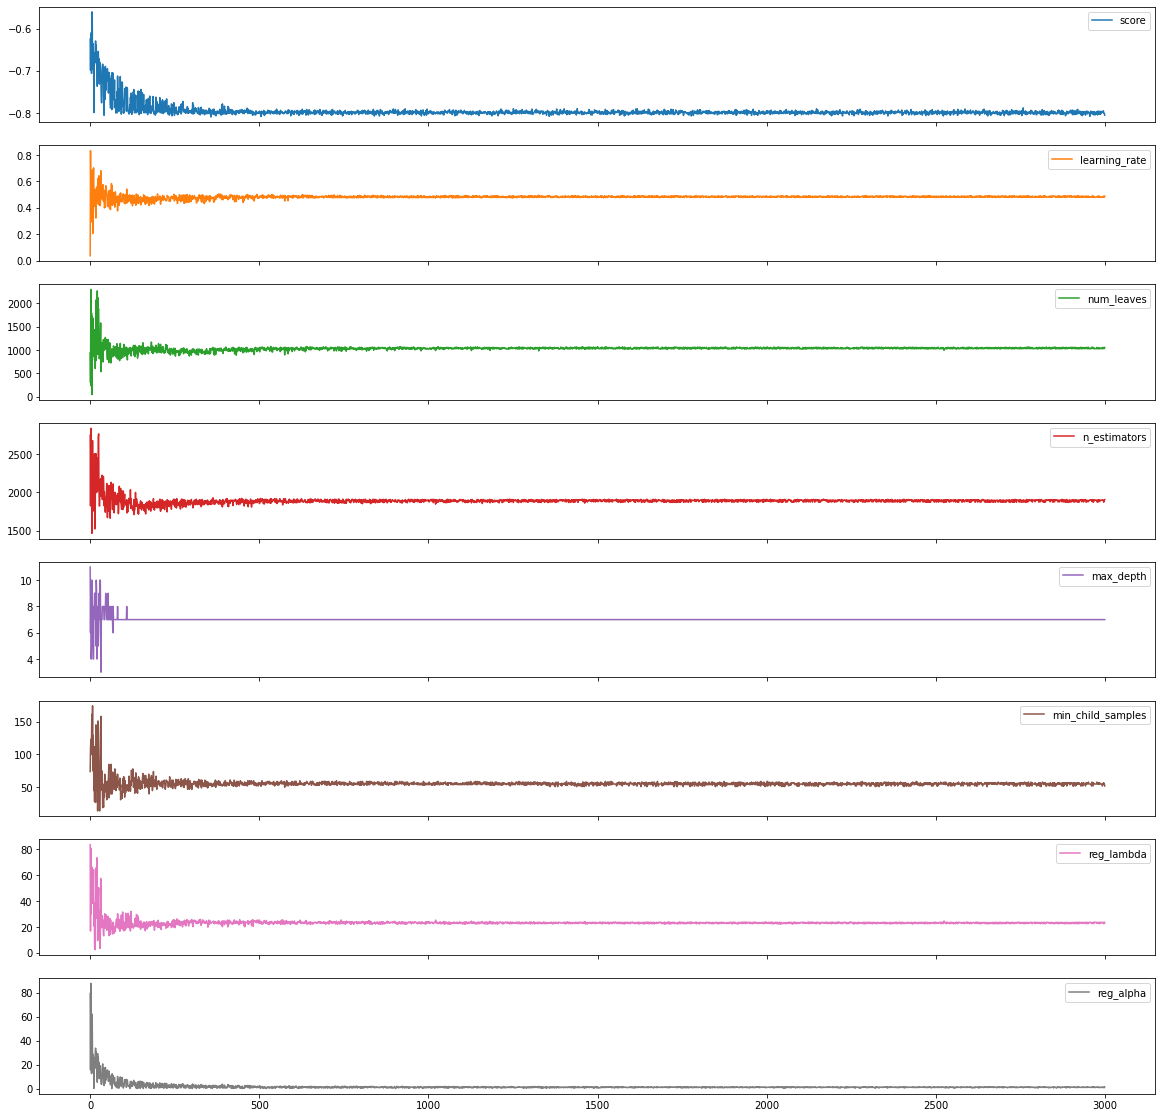

In [39]:
anneal_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['num_leaves'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_samples'][0],
                      x['misc']['vals']['reg_lambda'][0],
                      x['misc']['vals']['reg_alpha'][0]] for x in trials_anneal.trials])

anneal_results_df=pd.DataFrame(anneal_results,
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
anneal_results_df.plot(subplots=True,figsize=(20, 20))

In [27]:
%%time
trials_tpe = Trials()
result_tpe = fmin(fn=optimization_function_hp, space = space_hyperopt, algo = tpe.suggest, max_evals = EVALS_IN_HYPEROPT, trials = trials_tpe)
print(result_tpe)

100%|█████████████████████████████████████████| 3000/3000 [1:28:00<00:00,  1.76s/trial, best loss: -0.8211451802507836]
{'learning_rate': 0.23117425625068863, 'max_depth': 11.0, 'min_child_samples': 2.0, 'n_estimators': 511.0, 'num_leaves': 2450.0, 'reg_alpha': 0.17852541067531755, 'reg_lambda': 78.89269924528269}
CPU times: total: 8min 42s
Wall time: 1h 28min


In [28]:
result_tpe["num_leaves"] = int(result_tpe["num_leaves"])
result_tpe["n_estimators"] = int(result_tpe["n_estimators"])
result_tpe["max_depth"] = int(result_tpe["max_depth"])
result_tpe["min_child_samples"] = int(result_tpe["min_child_samples"])
lgbm_tpe = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_tpe.set_params(**result_tpe)
print_params(lgbm_tpe)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.23117425625068863
max_depth: 11
min_child_samples: 2
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 511
n_jobs: -1
num_leaves: 2450
objective: None
random_state: 42
reg_alpha: 0.17852541067531755
reg_lambda: 78.89269924528269
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

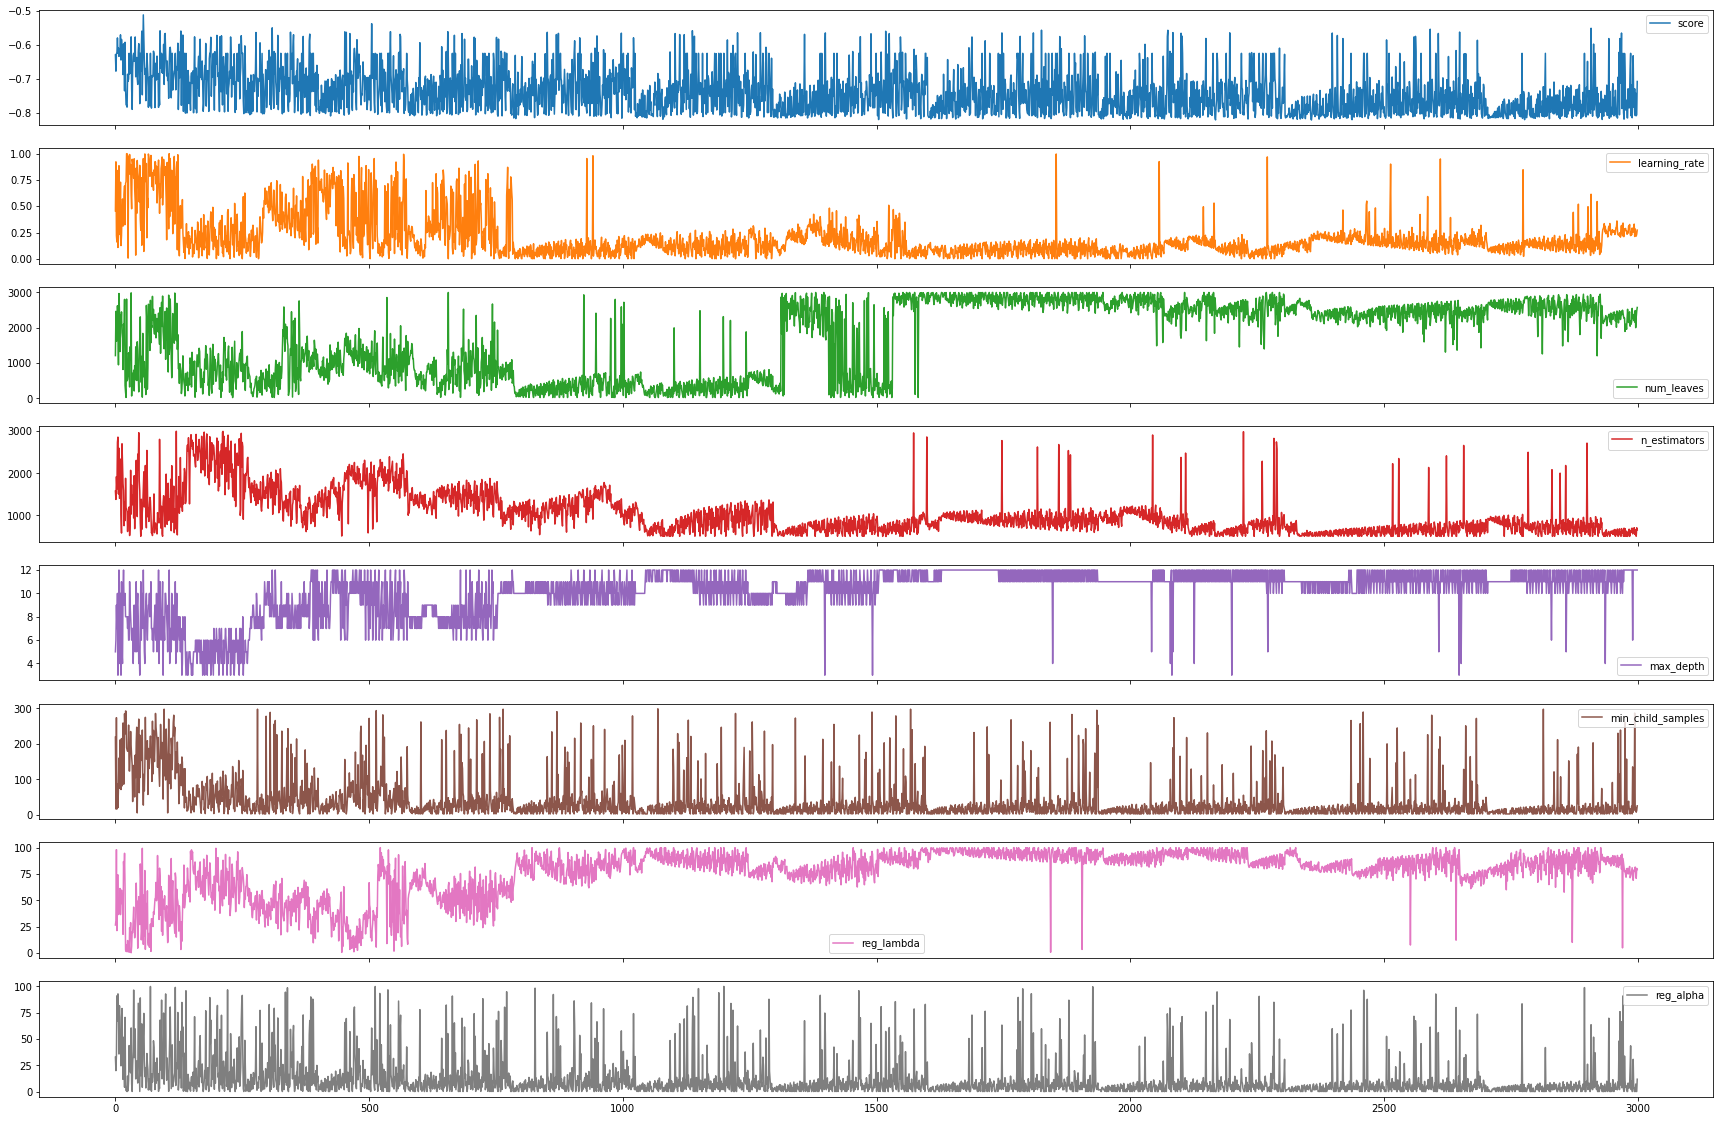

In [29]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['num_leaves'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_samples'][0],
                      x['misc']['vals']['reg_lambda'][0],
                      x['misc']['vals']['reg_alpha'][0]] for x in trials_tpe.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
tpe_results_df.plot(subplots=True,figsize=(30, 20))

In [30]:
def optimize_bayesian(params, param_names ,x, y):
    params = dict(zip(param_names, params))
    model = LGBMClassifier(**params)
    return -1.0 * np.mean(cross_val_score(model, x, y, cv=FOLDS, scoring=SCORING, n_jobs=N_JOBS))

In [31]:
%%time
param_space = [
               space.Real(0.001,1, prior = "uniform", name = "learning_rate"),
               space.Integer(20,3000, name = "num_leaves"),
               space.Integer(500,3000, name = "n_estimators"),
               space.Integer(3,12, name = "max_depth"),
               space.Integer(2,300, name = "min_child_samples"),
               space.Real(0.01,100, prior = "uniform", name = "reg_lambda"),
               space.Real(0.01,100, prior = "uniform", name = "reg_alpha")
]

param_names=[
             "learning_rate",
             "num_leaves",
             "n_estimators",
             "max_depth",
             "min_child_samples",
             "reg_lambda",
             "reg_alpha",
]

optimization_function_bayesian = partial(optimize_bayesian, param_names = param_names, x = X, y= y)
result_bayesian = gp_minimize(optimization_function_bayesian, dimensions = param_space, n_calls = EVALS_IN_BAYESIAN, n_initial_points=10, verbose=10, n_jobs= N_JOBS)

bayesian_parameters = dict(zip(param_names, result_bayesian.x))
print(bayesian_parameters)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3724
Function value obtained: -0.5922
Current minimum: -0.5922
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3574
Function value obtained: -0.6939
Current minimum: -0.6939
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1607
Function value obtained: -0.5897
Current minimum: -0.6939
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1924
Function value obtained: -0.5785
Current minimum: -0.6939
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1041
Function value obtained: -0.5813
Current minimum: -0.6939
Iteration No: 6 started. 

In [32]:
lgbm_bayesian = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_bayesian.set_params(**bayesian_parameters)
print_params(lgbm_bayesian)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.5592623472278075
max_depth: 11
min_child_samples: 2
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 500
n_jobs: -1
num_leaves: 3000
objective: None
random_state: 42
reg_alpha: 0.01
reg_lambda: 0.01
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

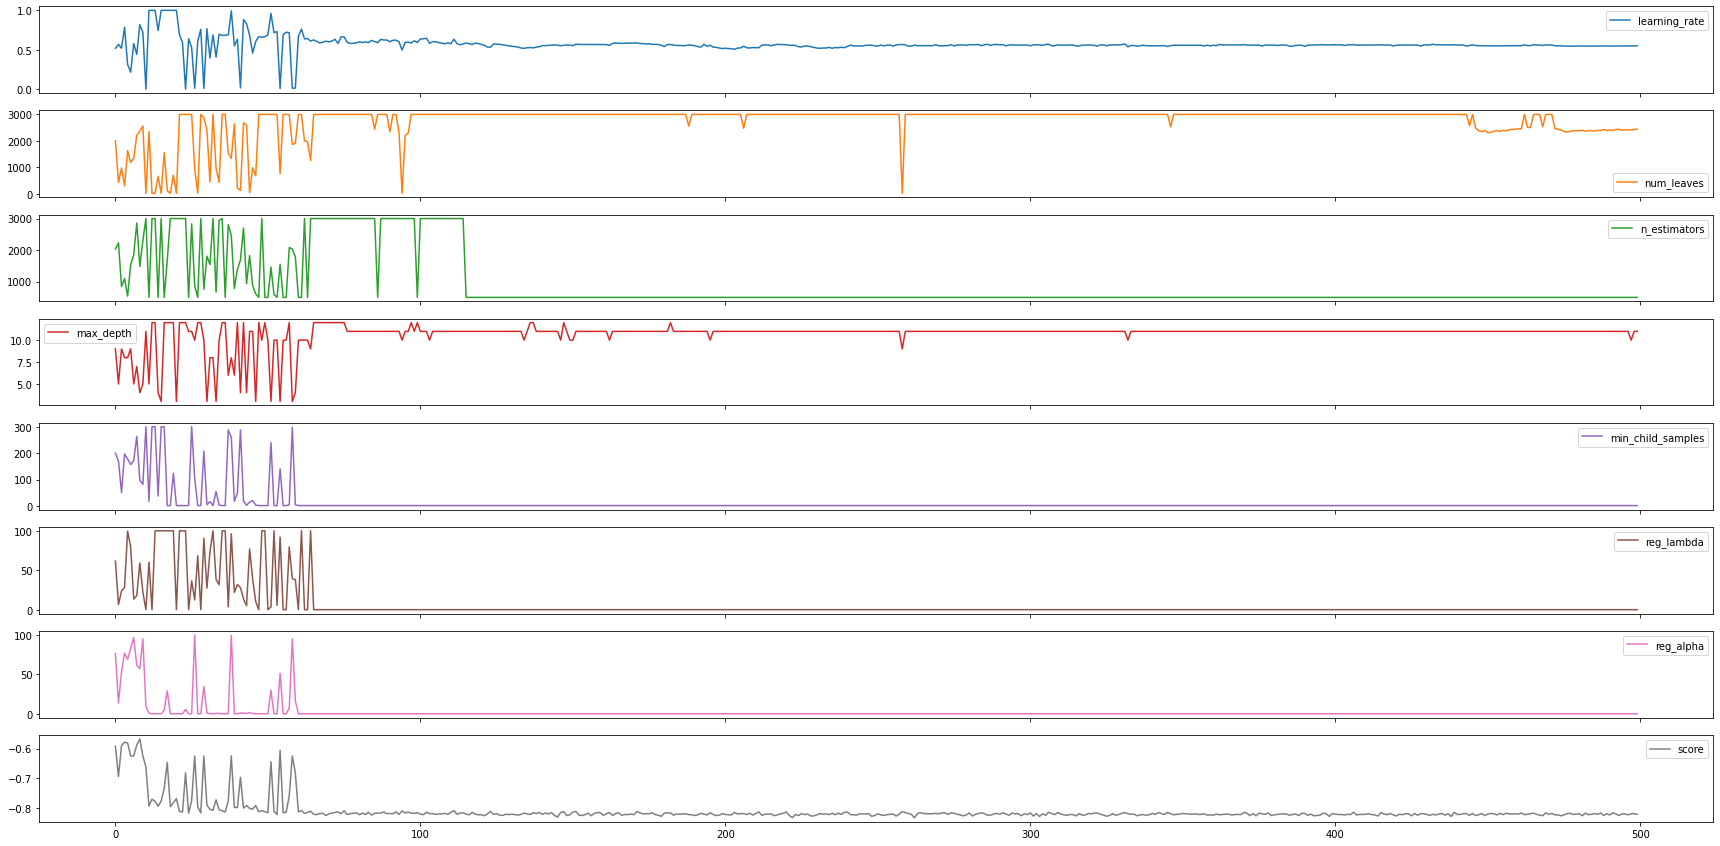

In [33]:
bayesian_results_df = pd.DataFrame(result_bayesian.x_iters)
list_of_scores = result_bayesian.func_vals.tolist()
bayesian_results_df['score'] = list_of_scores

bayesian_results_df.columns=('learning_rate','num_leaves','n_estimators','max_depth', "min_child_samples", "reg_lambda", "reg_alpha",'score')
bayesian_results_df.plot(subplots=True,figsize=(30, 15))

In [40]:
print_scores_with_cross_val(lgbm_classic, "bez optimizacije")
print("\n")
print_scores_with_cross_val(lgbm_grid_search, "s Grid Search-om")
print("\n")
print_scores_with_cross_val(lgbm_random_search, "s Random Searchom-om")
print("\n")
print_scores_with_cross_val(lgbm_anneal, "s Hyperopt-Anneal")
print("\n")
print_scores_with_cross_val(lgbm_tpe, "s Hyperopt-Tpe")
print("\n")
print_scores_with_cross_val(lgbm_bayesian, "s Bayesian")

Točnost modela bez optimizacije sa unakrsnom provjerom: 79.39380877742947%
Standardna devijacija modela bez optimizacije sa unakrnsom provjerom: 1.1819589781155915 %
ROC AUC vrijednost modela bez optimizacije : 83.5367043551089 %
F1 vrijednost modela bez optimizacije : 70.73023975459594 %


Točnost modela s Grid Search-om sa unakrsnom provjerom: 81.8639302507837%
Standardna devijacija modela s Grid Search-om sa unakrnsom provjerom: 1.3300219613433866 %
ROC AUC vrijednost modela s Grid Search-om : 84.98621649916247 %
F1 vrijednost modela s Grid Search-om : 73.69921855230514 %


Točnost modela s Random Searchom-om sa unakrsnom provjerom: 80.8317985893417%
Standardna devijacija modela s Random Searchom-om sa unakrnsom provjerom: 1.6897587800188894 %
ROC AUC vrijednost modela s Random Searchom-om : 84.85496021775545 %
F1 vrijednost modela s Random Searchom-om : 73.96553467669015 %


Točnost modela s Hyperopt-Anneal sa unakrsnom provjerom: 80.9264302507837%
Standardna devijacija modela s Hy

Text(0, 0.5, 'best_cumulative_score')

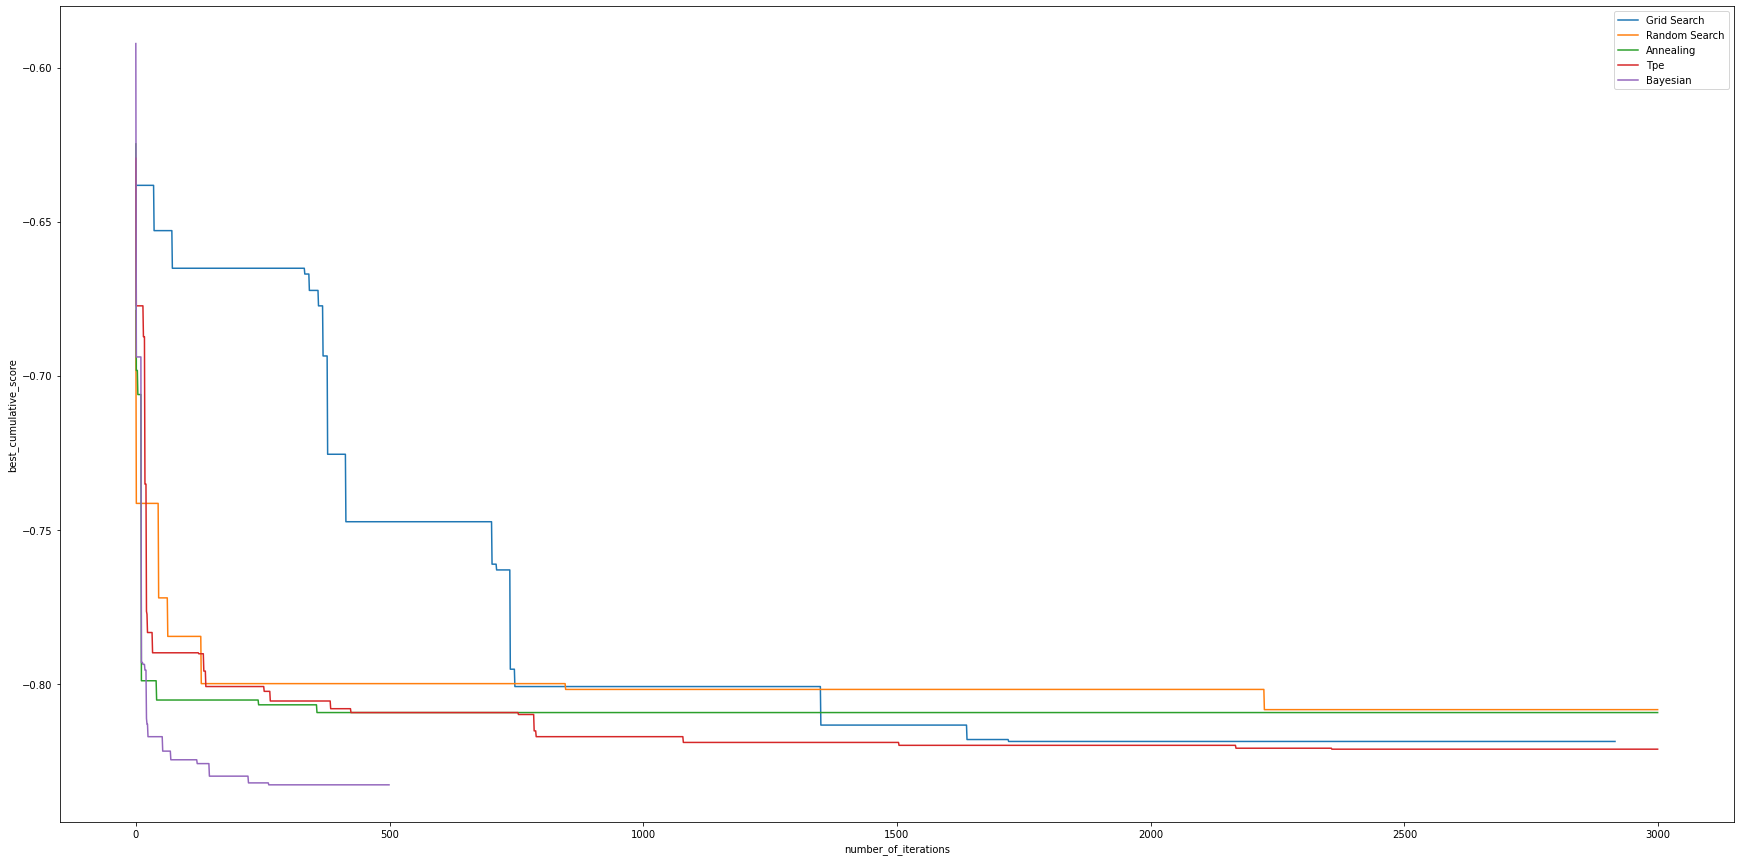

In [41]:
scores_df=pd.DataFrame(index=range(3000))
scores_df['Grid Search']=grid_search_results_df['score'].cummin()
scores_df['Random Search']=random_search_results_df['score'].cummin()
scores_df['Annealing']=anneal_results_df['score'].cummin()
scores_df['Tpe'] = tpe_results_df['score'].cummin()
scores_df['Bayesian'] = bayesian_results_df['score'].cummin()

ax = scores_df.plot(figsize=(30, 15))

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")